# CRP 2021 Data Analysis

In [468]:
# Import Data and Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import re

dataFrame = pd.read_excel("CRP2021_raw_data.xlsx")

## Preprocessing data and Basic Analysis
Includes removing all text and normalising data, analysing amount of unanswered questions etc

In [469]:
'''
# Normalise all data so all non-responses have the same form throughout the data set (using negative numbers for non-response)
question_number = list(dataFrame.columns)
for index, response in dataFrame.iterrows():
    for question in question_number:
        prefix_regex = re.search(r'^Q\d+', question)
        prefix = prefix_regex.group(0)
        all_zeros = True
        for inner_question in dataFrame:
            if not inner_question.startswith(prefix):
                continue
            if dataFrame.loc[index, question] != 0:
                all_zeros = False
            break
        if all_zeros:
            dataFrame[index, question] = -1
dataFrame
'''

"\n# Normalise all data so all non-responses have the same form throughout the data set (using negative numbers for non-response)\nquestion_number = list(dataFrame.columns)\nfor index, response in dataFrame.iterrows():\n    for question in question_number:\n        prefix_regex = re.search(r'^Q\\d+', question)\n        prefix = prefix_regex.group(0)\n        all_zeros = True\n        for inner_question in dataFrame:\n            if not inner_question.startswith(prefix):\n                continue\n            if dataFrame.loc[index, question] != 0:\n                all_zeros = False\n            break\n        if all_zeros:\n            dataFrame[index, question] = -1\ndataFrame\n"

In [470]:
# remove qualitative data (save NLP for later if time)
data = dataFrame.drop(columns=["Q10_11_text", "Q11_9_text", "Q12l_text", "Q13_6_text", "Q17_7_text", "Q19g_text", "Q67_7_text", "Q21g_text", "Q23h_text", "Q24a", "Q24b", "Q24c", "Q24d", "Q26k_text", "Q27a", "Q27b", "Q27c", "Q27d", "Q29h_text", "Q30a", "Q30b", "Q30c", "Q30d", "Q32j_text", "Q33a", "Q33b", "Q33c", "Q33d", "Q40a", "Q43h", "Q43h_text", "Q44a", "Q44b", "Q43h", "Q46l_text", "Q47a", "Q47b", "Q50a", "Q50b", "Q50c", "Q50d", "Q51a", "Q51b", "Q51c", "Q51d", "Q52", "Q53", "Q53", "Q55l_text", "Q56", "Q58_2_text", "Q59l_text", "Q60", "Q62l_text", "Q64l_text", "Q65"])

In [471]:
# Delete 2nd row (question)
question_title_row = list(dataFrame.iloc[0])
data = data.drop([0])

In [472]:
# Parse all data as numbers
for column in data.columns:
    data[column] = pd.to_numeric(data[column])

### 1. Bar chart for number of unanswered questions

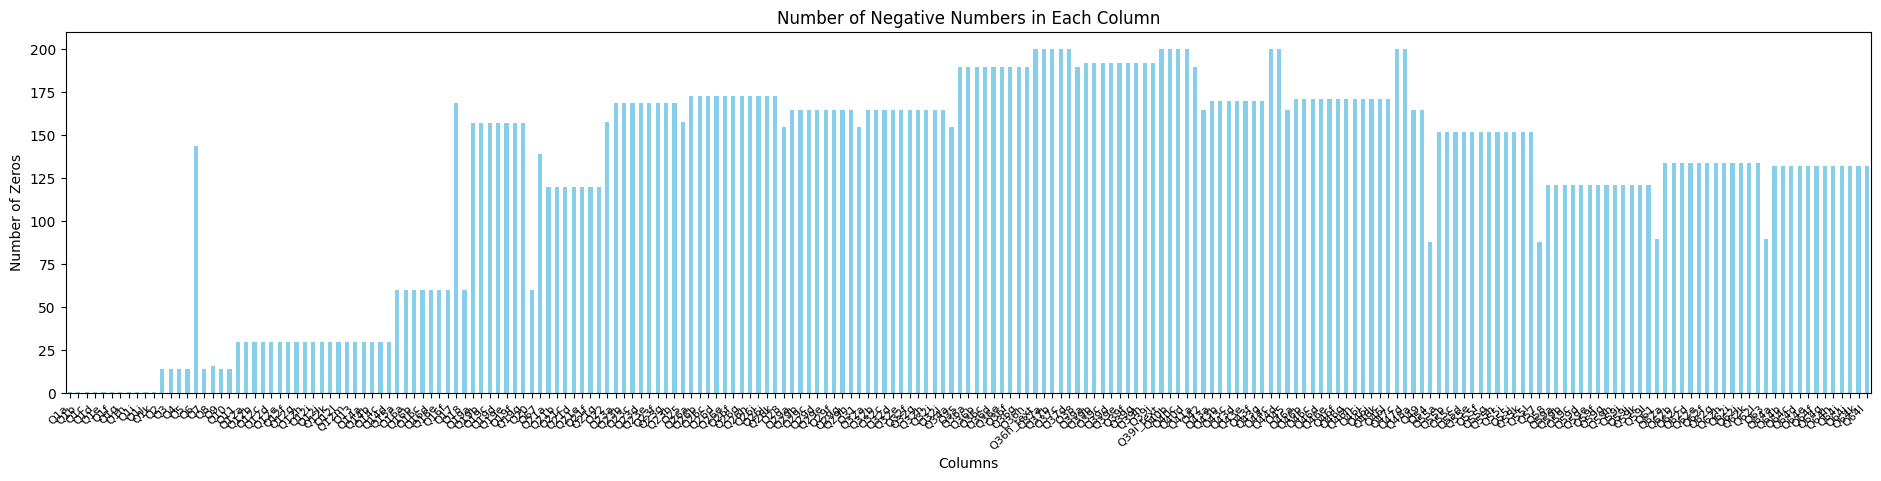

In [473]:
# Count the number of negative in each column
# Pal says: change this to be a percentage of responses that are 0 for each question instead
neg_counts = (data < 0).sum()
# Plotting the bar graph
plt.figure(figsize=(20, 6))
neg_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Negative Numbers in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Zeros')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust the fontsize and alignment
plt.tight_layout(pad=5)  # Adjust layout to make room for labels
plt.show()

### 2. Distribution of Missing Values
This histogram highlights the percentage of missing values across all features, showing how prevalent missing data is in the dataset.

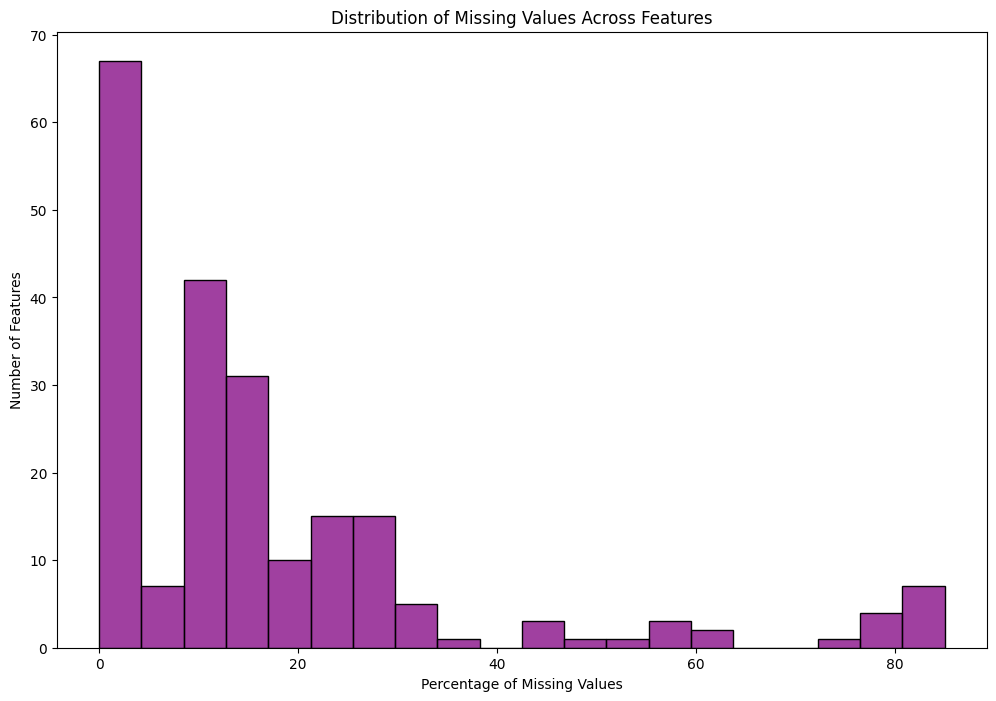

In [474]:
missing_values = (data == 0).mean() * 100
plt.figure(figsize=(12, 8))
sns.histplot(missing_values, bins=20, color="purple")
plt.title("Distribution of Missing Values Across Features")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Number of Features")
plt.show()

In [475]:
# Replace negative numbers with null values
data = data.clip(lower=0,)
data.shape

(200, 215)

In [476]:
### Ideas that weren't necessary
# Flatten multi-select columns into one CSV column
# relate discrete data with survey answers

## Basic Data Analysis

### 3. Correlation Matrix Heatmap
The heatmap shows the correlation coefficients between all pairs of features. High correlations (close to 1 or -1) indicate that the features are linearly related.

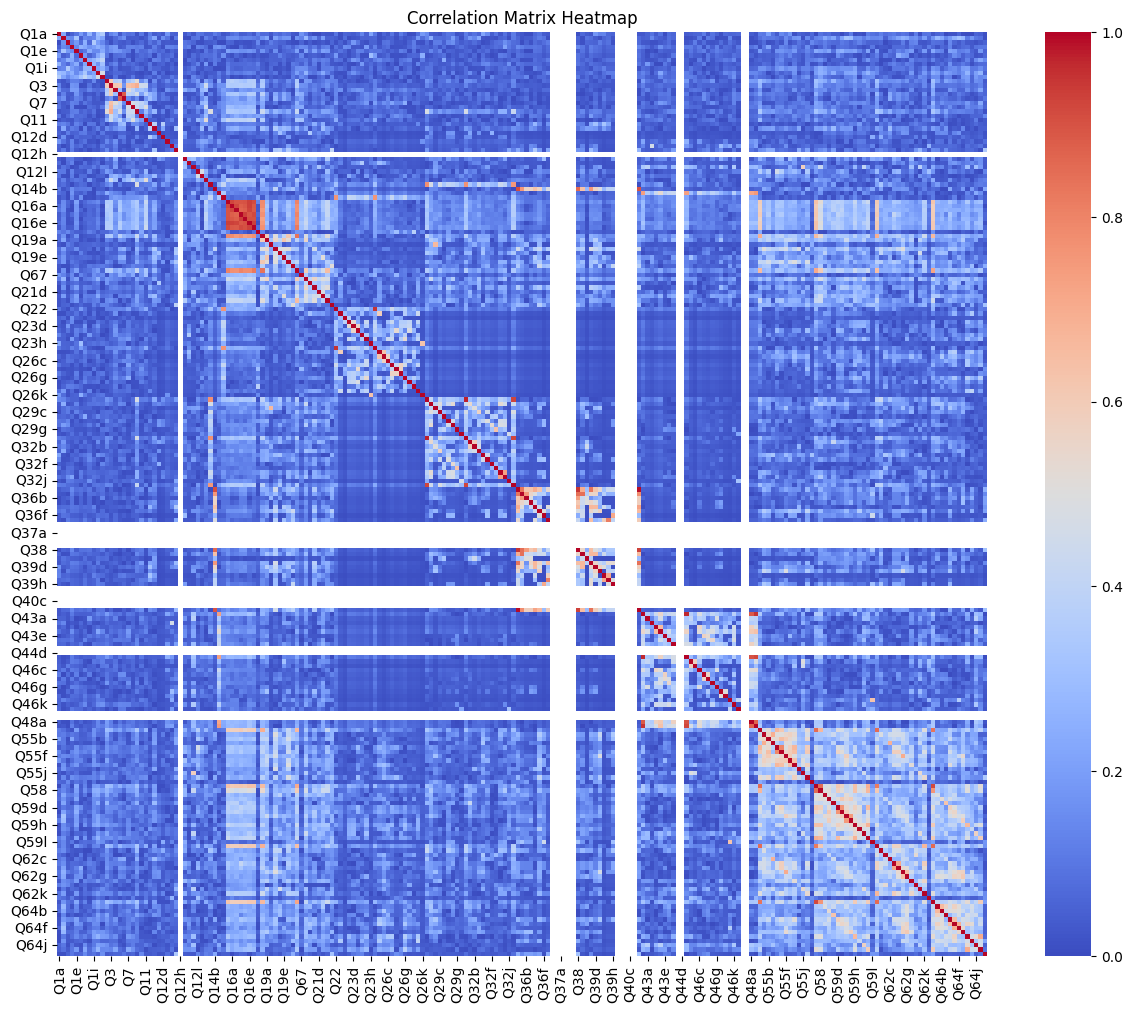

In [477]:
# Change to use absolute values in range [0-1] instead, or change the color so it's red-white-red
plt.figure(figsize=(15, 12))
correlation_matrix = data.corr()
absolute_array = np.absolute(correlation_matrix )
sns.heatmap(absolute_array, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

### 4. Principal Component Analysis (PCA) for Dimensionality Reduction
The PCA plot demonstrates the cumulative explained variance by the principal components. This helps determine the number of components needed to explain a significant portion of the variance in the dataset.

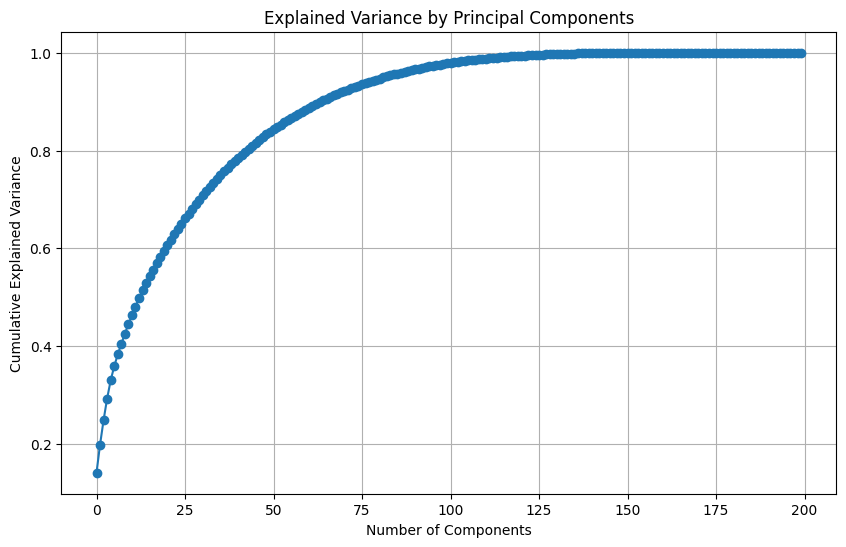

In [478]:
from sklearn.decomposition import PCA

# Normalize the data
normalized_data = (data - data.mean()) / data.std()
pca = PCA()
pca_data = pca.fit_transform(normalized_data.fillna(0))

# Plot the explained variance by each principal component
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

### 5. Feature Importance using Random Forest
This algorithm loops through each question and runs a random forest assuming that question as the "label" variable. It measures "feature importance", showing how clear the separation determined by the forest is. Question 3 has the best score, meaning that it is the single clearest determinant for the dataset (in a way).

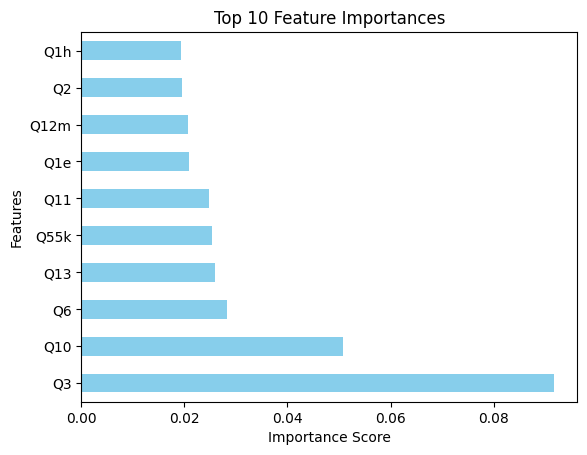

In [479]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(data.fillna(0), np.random.rand(data.shape[0]))  # Random target for illustration
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=data.columns)
feature_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## Finding correlations in data

In [480]:
# calculate the covariance matrix
# there are 216 variables, so this will be of shape (216, 216). Each point is how much one variable correlates to another (scale between -1 and 1 inclusive).
# The main diagonal corresponds to the correlation of each variable to itself, so all values will be 1.
# The higher the absolute value (outside the main diagonal), the higher the chance of a meaningful variable causation
cov_mat = np.corrcoef(data, rowvar=False)
cov_mat

/Users/carolinemorton/Library/Caches/pypoetry/virtualenvs/crp2021-bpNPsJmt-py3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/carolinemorton/Library/Caches/pypoetry/virtualenvs/crp2021-bpNPsJmt-py3.11/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[ 1.        ,  0.22701095, -0.00574449, ...,  0.05551306,
         0.0462033 ,  0.0114151 ],
       [ 0.22701095,  1.        ,  0.16645008, ...,  0.10126657,
         0.08311889,  0.00826898],
       [-0.00574449,  0.16645008,  1.        , ...,  0.01236705,
         0.03320435, -0.05161398],
       ...,
       [ 0.05551306,  0.10126657,  0.01236705, ...,  1.        ,
         0.46045551, -0.05188063],
       [ 0.0462033 ,  0.08311889,  0.03320435, ...,  0.46045551,
         1.        ,  0.08866281],
       [ 0.0114151 ,  0.00826898, -0.05161398, ..., -0.05188063,
         0.08866281,  1.        ]])

In [481]:
# Find the highest correlations

best_correlations = []
seen_pairs = []
for row_index, row in enumerate(cov_mat):
    for col_index, score in enumerate(row):
        if col_index == row_index:
            # we are on the main diagonal, so ignore this element
            continue
            
        if np.isnan(score):
            # Some scores are nan (e.g. if a text variable is involved)
            continue
            
        row_name = data.columns[row_index]
        row_desc = question_title_row[row_index]
        if isinstance(row_desc, str):
            row_name +=  " " +row_desc
        col_name = data.columns[col_index]
        col_desc = question_title_row[col_index]
        if isinstance(col_desc, str):
            col_name += " " + col_desc
        
        skip = False
        for b1, b2, _ in best_correlations:
            if (row_name == b1 and col_name == b2) or (row_name == b2 and col_name == b1):
                # deduplicate data points
                skip = True
                break
        if skip:
            continue
            
        best_correlations.append((row_name, col_name, np.abs(score)))
        
best_correlations_dtype = [('between_1', "U300"), ("between_2", "U300"), ("score", float)]
best_correlations = np.array(best_correlations, dtype=best_correlations_dtype)
best_correlations = np.sort(best_correlations, order="score")
best_correlations = np.flip(best_correlations)
best_correlations

array([('Q35 By providing adequate information support about the possibilities of collaboration options for Slovenian intellectuals abroad (e.g., in the field of science and education).', 'Q41a Do you think that Slovenia works enough to promote collaboration and networking of Slovenian cultural figures abroad?', 9.89428879e-01),
       ('Q28 Vpišite besedilo', 'Q31 By supporting the academic exchange of knowledge, for example by financing joint research of Slovenian and foreign universities, opening up the possibilities of guest lectures at Slovenian universities etc.', 9.74679602e-01),
       ('Q42 By providing financial support to organizations that work with this purpose.', 'Q45 Vpišite besedilo', 9.65847483e-01),
       ...,
       ('Q1k Buying and using Slovenian products', 'Q26b By providing adequate information support about the possibilities of collaboration and networking of Slovenians abroad on different fields.', 1.74346269e-19),
       ('Q14a Other organizations in my count